In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Principal Component Analysis

Principal component analysis is a broadly used unsupervised method that is fast and flexible. It is primarly used for dimensionality reduction in data, but can also be used as a tool for visualization, noise filtering, and feature engineering.

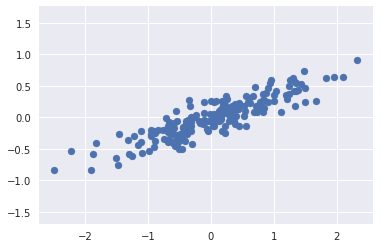

In [2]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

We can clearly see a linear relationship in the data, but when we are talking about an unsupervised learning problem, we don't want to use this to predict a $y$-value, we to learn about the relationship between the $x$ and $y$ values.

In principal component analysis, this relationship is quantified by finding a list of the **principal axes** in the data, and using those axes to describe the dataset. 

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [4]:
pca.components_

array([[-0.94446029, -0.32862557],
       [-0.32862557,  0.94446029]])

In [5]:
pca.explained_variance_

array([0.7625315, 0.0184779])

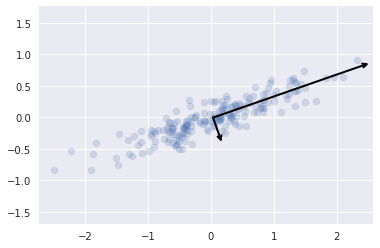

In [6]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, -pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

The vector are the princical axes of the data with a length that indicates their importance or the measure of variance of the data when projected.

The projection of each data point onto the principal axes are the "principal components" of the data.

This is an *affine transformation*, meaning it is composed of translation, rotation, and uniform scaling.

### Dimensionality Reduction

When using PCA for dimensionality reduction we are zeroing out the smallest principal components. This results in a lower-dimensional projection that preserces the maximal data variance.

In [7]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


The data has been transoformed from two dimensional, to one, let's plot the two together;

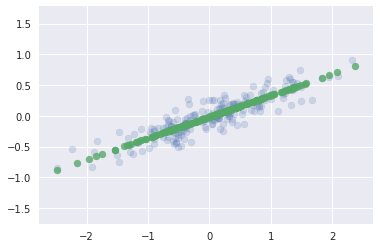

In [8]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

We can clearly see that the components that followed the shorter, slightly up-pointing vector have been removed. This information was along the least important principal axis and is not gone, leaving the components with the highest variance.

This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.

### Visualization: Hand-written Digits

The benefit from dimensionality reduction is difficult to see with only two dimensions, so let's look at some high dimensional data.

In [9]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

Let's project our 64 dimensional (8x8 pixel) data to just 2 dimensions. This will allows us to the plot the data.

In [10]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


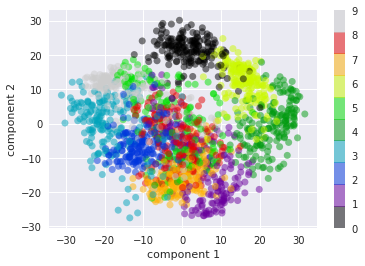

In [12]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

The full data is 64 dimensional, these points are projection of each along the highest variance directions. We found an optimal transformation to see the layout of the digits in two dimensions without needing to reference the labels.

So, what do the components mean?

### Components

Each image in the training set can be thought of as a vector;

$x = [x_1,x_2,x_3,\dots,x_64]$

We can think of construction the image from a pixel basis, essentially multiplying each element of the vector by the pixel it describes.

One way to reduce the dimension would be to zero out all but a few of these basis vectors, but this would be very representative as it would throw out all those zeroed out pixels!

THis pixel-wise basis is not the only basis, we could use different basis functions that each contain some pre-defined contribution from each pixel.

PCA is the processes of choosing the optimal basis functions such that the first few of them are enough to reconstruct a bulk of the elements in the datset.

The principal components, which act as the low-dimensional representation of our data, are simply the coefficients that multiply each of the elements in this series.

### Choosing the Number of Components

We can look at the cumulative *explained variance ratio* as a function of the number of components.

This tells us how much of the variance is contained in the first $n$ components at each part of the curb. So, the first 10 components contain 75% of the variance and we only 50 components to represent almost 100% of the variance.

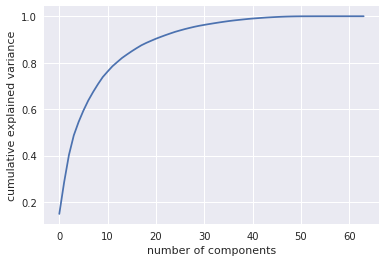

In [13]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## Noise Filtering

The idea here is that any component with variance much larger than the effect of the noise should be mostly unaffected by the noise. This means ideally if you reconstruct the data using just the largest subset of principal components, you should be preferentially keeping the signal and throwing out the noise.

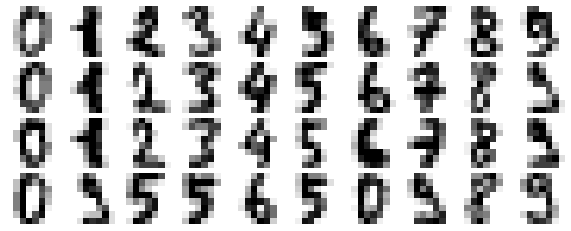

In [14]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

The digit dataset doesn't have a lot of noise, so let's add some.

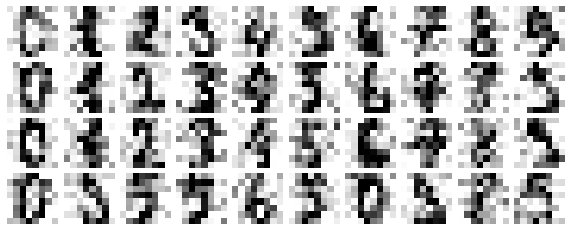

In [15]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

Now we can train a PCA on the data and instead of choosing the number of components, we can specify that the projection preserve 50% of the variance.

In [16]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

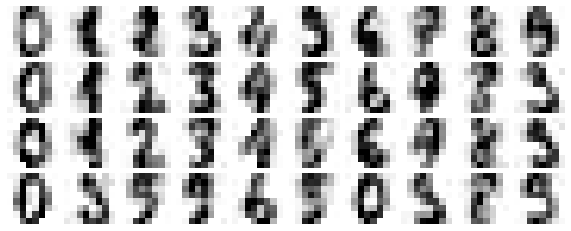

In [17]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

This signal preserving/noise filtering property makes PCA a very useful feature selection routine—for example, rather than training a classifier on very high-dimensional data, you might instead train the classifier on the lower-dimensional representation, which will automatically serve to filter out random noise in the inputs.

### Example: Eigenfaces

In [18]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


This is a high dimensional dataset (nearly 3,000), so we can use a PCA with a randomized method to approximate the first $N$  principal components much more quickly.

In [20]:
pca = PCA(n_components = 150, svd_solver='randomized') 
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

These components are known as "eigenvectors," and we can use them to visualize the images associated with the principal components.

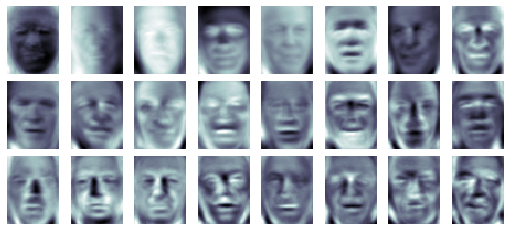

In [21]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

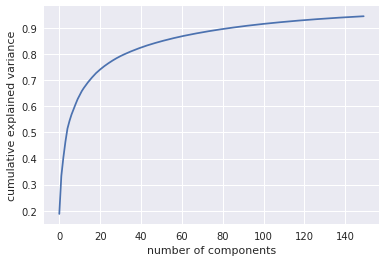

In [22]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

We see that these 150 components account for just over 90% of the variance. That would lead us to believe that using these 150 components, we would recover most of the essential characteristics of the data.

In [25]:
pca = PCA(n_components = 150, svd_solver='randomized').fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

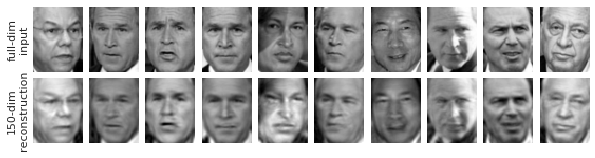

In [26]:
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

The top row here shows the input images, while the bottom row shows the reconstruction of the images from just 150 of the ~3,000 initial features.

What this means is that our classification algorithm needs to be trained on 150-dimensional data rather than 3,000-dimensional data, which depending on the particular algorithm we choose, can lead to a much more efficient classification.

### Summary

With any high-dimensional dataset it can be useful with PCA in order to;

+ visualize the relationship between points (as we did with the digits)
+ understand the main variance in the data (as we did with the eigenfaces)
+ understand the intrinsic dimensionality (by plotting the explained variance ratio). 

PCA offers a straightforward and efficient path to gaining insight into high-dimensional data.

PCA's main weakness is that it tends to be highly affected by outliers in the data. 

For this reason, many robust variants of PCA have been developed, many of which act to iteratively discard data points that are poorly described by the initial components.